In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
!pip install minisom
from minisom import MiniSom

!pip install lime
import lime
import lime.lime_tabular




  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=d2e60fb6fe0495a506ff2223f95a1c31e6245ce605cfb1b8d92f8e6a3cc40356
  Stored in directory: /root/.cache/pip/wheels/c8/29/ba/ee521d9a6af783a1e1efb1831fe4afdf526613849b3f58175b
Successfully built minisom
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=54116be7566264e629a665e499f3d0d34a7cc14ee76c2754d5f8961263d63b4b
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [2]:
Data= pd.read_csv('/content/classData.csv')

display(Data, Data.shape)
display(Data.columns)

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983
...,...,...,...,...,...,...,...,...,...,...
7856,0,0,0,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598
7857,0,0,0,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407
7858,0,0,0,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104
7859,0,0,0,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690


(7861, 10)

Index(['G', 'C', 'B', 'A', 'Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc'], dtype='object')

In [3]:
# Define the fault feature columns
fault_features = ['G', 'C', 'B', 'A']
print("fault_columns:", Data.columns[0:4].tolist())

# Combine the fault feature columns into a single binary string
Data['Fault_string'] = Data[fault_features].astype(str).agg(''.join, axis=1)

print("fault statements", Data['Fault_string'].unique())

# Define the mapping from binary codes to fault type names
fault_mapping = {
    '0000': 'No Fault',
    '1001': 'LG Fault',
    '0110': 'LL Fault',
    '1011': 'LLG Fault',
    '0111': 'LLL Fault',
    '1111': 'LLLG Fault'
}

# Apply the mapping to create a new 'Fault_Type' column
Data['Fault_Type'] = Data['Fault_string'].map(fault_mapping)
# Verify the mapping
print(Data[['Fault_string', 'Fault_Type']].drop_duplicates())

count_data= Data['Fault_Type'].value_counts()
print(count_data)

fault_columns: ['G', 'C', 'B', 'A']
fault statements ['1001' '1011' '0110' '0111' '1111' '0000']
     Fault_string  Fault_Type
0            1001    LG Fault
1129         1011   LLG Fault
2263         0110    LL Fault
3267         0111   LLL Fault
4363         1111  LLLG Fault
5496         0000    No Fault
Fault_Type
No Fault      2365
LLG Fault     1134
LLLG Fault    1133
LG Fault      1129
LLL Fault     1096
LL Fault      1004
Name: count, dtype: int64


In [4]:
from imblearn.over_sampling import RandomOverSampler

X = Data.drop('Fault_Type', axis=1)
y = Data['Fault_Type']

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Combine the resampled features and labels into a new DataFrame
Data_resampled = pd.concat([X_resampled, y_resampled], axis=1)
Data_resampled.drop(['G','C','B','A'], axis=1, inplace=True)

display(Data_resampled)


,Ia,Ib,Ic,Va,Vb,Vc,Fault_string,Fault_Type
0,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,1001,LG Fault
1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,1001,LG Fault
2,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,1001,LG Fault
3,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,1001,LG Fault
4,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,1001,LG Fault
...,...,...,...,...,...,...,...,...
14185,403.958999,16.721302,8.001666,0.290581,-0.566971,0.276391,1111,LLLG Fault
14186,785.317638,-751.435922,-33.872422,0.000248,-0.036854,0.036606,1111,LLLG Fault
14187,192.864226,-856.007552,663.181519,-0.031974,-0.007736,0.039710,1111,LLLG Fault
14188,785.886084,-43.361173,-742.527174,0.034603,-0.038390,0.003787,1111,LLLG Fault


Visualization fault Distribution in data

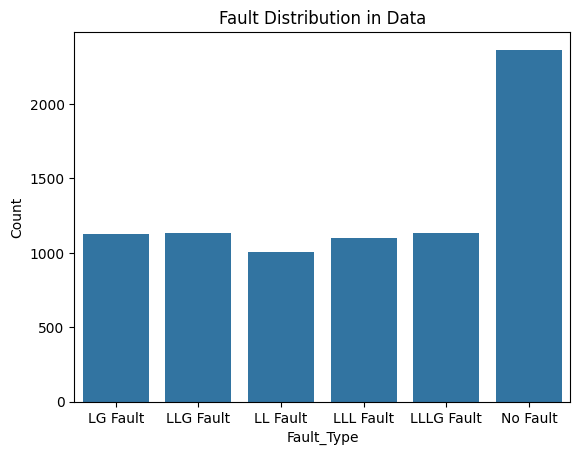

In [5]:
sns.countplot(x='Fault_Type', data=Data)
plt.title('Fault Distribution in Data')
plt.xlabel('Fault_Type')
plt.ylabel('Count')
plt.show()

In [6]:
# normalization
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(Data_resampled[['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']])
#normalized_data = scaler.fit_transform(X_train)

normalize_df = pd.DataFrame(normalized_data, columns=['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc'])
print(normalize_df)

             Ia        Ib        Ic        Va        Vb        Vc
0      0.413869  0.497571  0.543058  0.839985  0.384404  0.284358
1      0.309366  0.460370  0.505251  0.767607  0.391930  0.349258
2      0.215144  0.405429  0.449635  0.728956  0.399481  0.380317
3      0.163683  0.381381  0.424998  0.704108  0.407055  0.397513
4      0.135580  0.377775  0.420857  0.682749  0.414650  0.411189
...         ...       ...       ...       ...       ...       ...
14185  0.727698  0.512316  0.499464  0.749392  0.033211  0.733044
14186  0.943242  0.083273  0.476000  0.510649  0.462146  0.535347
14187  0.608386  0.024866  0.866587  0.484153  0.485706  0.537906
14188  0.943563  0.478758  0.078913  0.538900  0.460904  0.508287
14189  0.423018  0.118218  0.956684  0.477462  0.498630  0.531445

[14190 rows x 6 columns]


In [7]:

x= normalize_df[['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']]
y= Data_resampled['Fault_string']
#print(y)
print(x)

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
   x,y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

             Ia        Ib        Ic        Va        Vb        Vc
0      0.413869  0.497571  0.543058  0.839985  0.384404  0.284358
1      0.309366  0.460370  0.505251  0.767607  0.391930  0.349258
2      0.215144  0.405429  0.449635  0.728956  0.399481  0.380317
3      0.163683  0.381381  0.424998  0.704108  0.407055  0.397513
4      0.135580  0.377775  0.420857  0.682749  0.414650  0.411189
...         ...       ...       ...       ...       ...       ...
14185  0.727698  0.512316  0.499464  0.749392  0.033211  0.733044
14186  0.943242  0.083273  0.476000  0.510649  0.462146  0.535347
14187  0.608386  0.024866  0.866587  0.484153  0.485706  0.537906
14188  0.943563  0.478758  0.078913  0.538900  0.460904  0.508287
14189  0.423018  0.118218  0.956684  0.477462  0.498630  0.531445

[14190 rows x 6 columns]
Training set size: 11352
Testing set size: 2838


In [8]:

from torch.utils.data import TensorDataset, DataLoader

# Factorize y_train and y_test to ensure consecutive integer labels
y_train_encoded, uniques = pd.factorize(y_train)
y_test_encoded = pd.Series(y_test).map({k: v for v, k in enumerate(uniques)}).values


# Convert to tensors
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# Convert features to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [9]:
# Define the classifier model
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Initialize the model with output_dim equal to number of classes
model = Classifier(input_dim=6, hidden_dim=64, output_dim=6)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.7121
Epoch [20/100], Loss: 0.6313
Epoch [30/100], Loss: 0.5277
Epoch [40/100], Loss: 0.5120
Epoch [50/100], Loss: 0.3099
Epoch [60/100], Loss: 0.3229
Epoch [70/100], Loss: 0.4852
Epoch [80/100], Loss: 0.4213
Epoch [90/100], Loss: 0.5201
Epoch [100/100], Loss: 0.4355


In [10]:
# Evaluate the model's accuracy on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')


Accuracy of the model on the test set: 82.45%


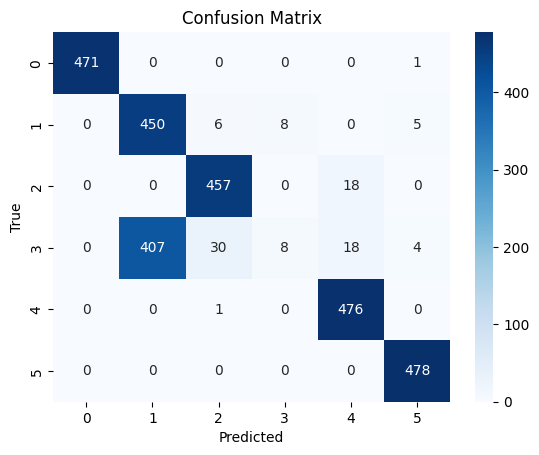

              precision    recall  f1-score   support

    No Fault       1.00      1.00      1.00       472
          LG       0.53      0.96      0.68       469
          LL       0.93      0.96      0.94       475
         LLG       0.50      0.02      0.03       467
         LLL       0.93      1.00      0.96       477
        LLLG       0.98      1.00      0.99       478

    accuracy                           0.82      2838
   macro avg       0.81      0.82      0.77      2838
weighted avg       0.81      0.82      0.77      2838



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all predictions and true labels
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=['No Fault', 'LG', 'LL', 'LLG', 'LLL', 'LLLG']))


In [12]:
def predict_fn(X):
    # تبدیل ورودی‌ها به Tensor
    X_tensor = torch.tensor(X, dtype=torch.float32)
    model.eval()  # اطمینان از اینکه مدل در حالت ارزیابی است
    with torch.no_grad():
        outputs = model(X_tensor)
        return outputs.numpy()  # تبدیل خروجی به numpy برای SHAP


  0%|          | 0/2838 [00:00<?, ?it/s]

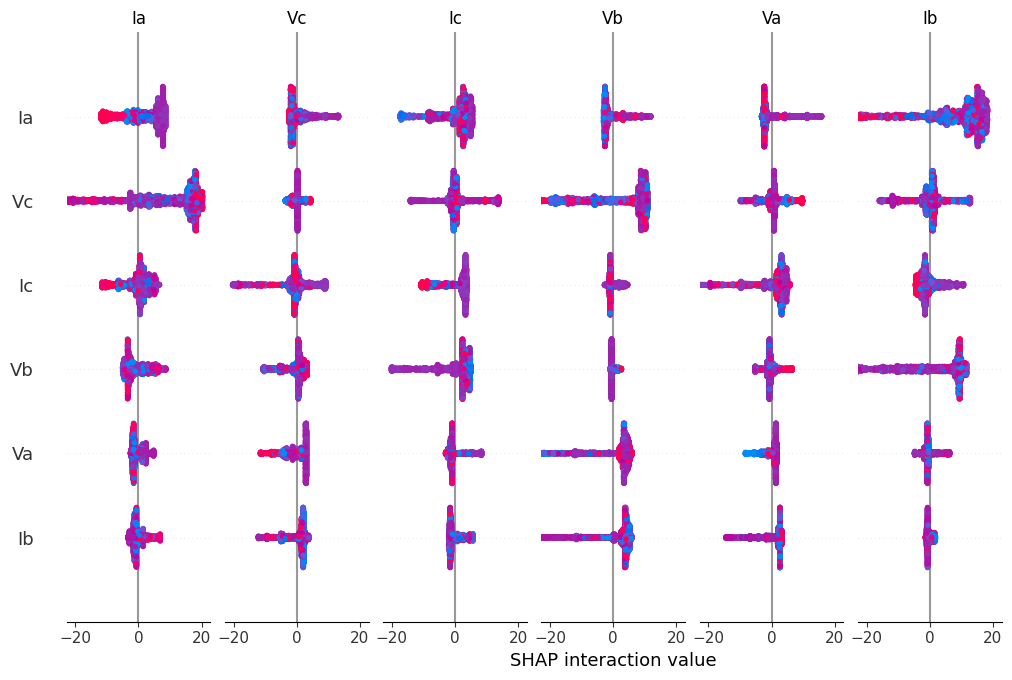

In [32]:
import shap
background_data = shap.sample(X_train_tensor.numpy(), 100)  # کاهش به 1000 نمونه
explainer = shap.KernelExplainer(predict_fn, background_data)

# محاسبه مقادیر SHAP
shap_values = explainer.shap_values(X_test_tensor.numpy())

# نمایش نمودار SHAP
shap.summary_plot(shap_values, X_test)



In [49]:
# برای انتخاب خروجی خاص
import shap
shap.initjs()

i = 0  # به عنوان مثال، برای اولین خروجی
shap.plots.force(explainer.expected_value[i], shap_values[i][0], feature_names=X_test.columns)


In [57]:
import numpy as np

# Loop through all features
for feature in X_test.columns:
    perturbed_data = X_test.copy()

    # Perturb the feature
    perturbed_data[feature] = np.random.permutation(perturbed_data[feature])

    # Get SHAP values for perturbed data
    perturbed_shap_values = explainer.shap_values(perturbed_data)

    # Compare original and perturbed SHAP values
    original_shap = np.mean(np.abs(shap_values), axis=0)
    perturbed_shap = np.mean(np.abs(perturbed_shap_values), axis=0)

    # Calculate change for the current feature
    change_in_shap = np.abs(original_shap[X_test.columns.get_loc(feature)] - perturbed_shap[X_test.columns.get_loc(feature)])

    print(f"Change in SHAP for '{feature}': {change_in_shap}")


  0%|          | 0/2838 [00:00<?, ?it/s]

Change in SHAP for 'Ia': [0.3240016  0.02270331 0.36747038 0.01369956 0.02060322 0.16786021]


  0%|          | 0/2838 [00:00<?, ?it/s]

Change in SHAP for 'Ib': [0.1646817  0.0133205  0.04391383 0.00270484 0.36738739 0.04246667]


  0%|          | 0/2838 [00:00<?, ?it/s]

Change in SHAP for 'Ic': [0.21930242 0.12414521 0.66559959 0.05574975 0.11388663 0.04786473]


  0%|          | 0/2838 [00:00<?, ?it/s]

Change in SHAP for 'Va': [0.10342771 0.1787893  0.01193337 0.20002161 0.01283215 0.20396976]


  0%|          | 0/2838 [00:00<?, ?it/s]

Change in SHAP for 'Vb': [0.19596433 0.10129158 0.01150362 0.10449154 0.04130885 0.85430279]


  0%|          | 0/2838 [00:00<?, ?it/s]

Change in SHAP for 'Vc': [0.21191211 0.1089681  0.08206654 0.27677437 0.13421654 0.22984953]
